In [1]:
import numpy as np
from gpkit import Model, Variable
from gpkit.nomials.nomial_math import SingleSignomialEquality,SignomialInequality
from gpkit import units
import gpkit
gpkit.SIGNOMIALS_ENABLED = True
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from constants import sigma, k, mu_earth, c, Q_s, R_earth

In [3]:
class Payload(Model):
    def setup(self):
        l = Variable("\\lambda", 500, "nm", "image payload wavelength")
        D = Variable("D_{ap}", "m", "aperture")
        mass = Variable("mass_pay", "kg", "payload mass")
        Xp = Variable('xp', 'm', 'diffraction limited resolution')
        Xp_req = Variable('xp_{req}', 'm', 'required resolution')
        npxw = Variable('n_{px}', 2000, '-', 'number of pixels along width')
        ground_width = Variable("W", "m", "ground footprint width")
        bppx = Variable("bppx", 8, "bit", "bit per pixel")
        total_data = Variable("TD", "MB", "total data over one orbit")

        return [
            ground_width == Xp * npxw,
            total_data == 2*np.pi*R_earth/Xp*npxw*bppx,
            Xp <= Xp_req,
            mass == 100*units("kg/m**1.5")*D**1.5
        ]

In [4]:
class Comms(Model):
    def setup(self):
        fdl = Variable("f_{DL}", "-", "fraction of downlink time")
        rgs = Variable("r_{GS}", "km", "max distance to ground station")
        
        f = Variable("f", 2.2, "GHz", "transmit frequency")
        l = Variable("\lambda", "m", "transmit wavelength")
        
        brate = Variable("brate", 85, "Mbps", "bit rate")
        breq = Variable("breq", "Mbps", "bit rate required")
        
        PT = Variable("P_{tx}", "W", "spacecraft transmit power")
        
        D_tx = Variable("D_{tx}", 0.3, "m", "spacecraft antenna diameter")
        Lother = Variable("L_{l}", 9.772372209558107, "-", "line loss") #1.58489
        
        G_rx = Variable("G_{rx}", "-", "ground receive gain")
        D_rx = Variable("D_{rx}", 5.3, "m", "ground receive diamater")
        Tsys = Variable("Tsys", 135, "K", "system temperature")
        eta = Variable("\\eta", 0.55, "-", "dish efficiency")
        ebno_req = Variable("ebno_{req}", 40, "-", "ebno required")
        
        ebno = Variable("ebno", "-", "engery per bit over noise spectral density")
        
        return [
            l == c / f,
            G_rx == eta*(np.pi * D_rx/l)**2, # SMAD 3 p. 556
            ebno == PT * eta * (D_tx / (4*rgs))**2 * G_rx / (Lother * k * Tsys * breq),
            ebno_req <= ebno
        ]

In [5]:
class Power(Model):
    def setup(self):
        P = Variable("P", "W", "spacecraft total power")
        A = Variable("A", "m^2", "surface area solar panels")
        day_fraction = Variable("td", "-", "not in-eclipse fraction")
        sa_spc_ene = Variable('spc', 25, 'W/kg', 'power density of solar arrays') 
        eta_s = Variable("\\eta_s", 0.29, "-", "solar panel efficiency")
        surrogate_constant = Variable('surr', 0.000103857, '1/km', 'surrogate value')
        mass_p = Variable("mass_p", 'kg', 'power subsystem mass')
        return [
            P == day_fraction * A * eta_s * Q_s,
            mass_p >= P/sa_spc_ene
        ]

In [6]:
class Satellite(Model):
    def setup(self):
        mass = Variable("m_t", 'kg', 'spacecraft total mass')
        stmass = Variable("m_st", "kg", "structural mass")
        
        constraints = []
        
        self.power = Power()
        self.comms = Comms()
        self.payload = Payload()
        
        constraints.extend([
            self.power["P"] >= self.comms["P_{tx}"],
            stmass >= 0.2*mass,
            mass >= self.power["mass_p"] + self.payload["mass_pay"] + stmass
        ])
        
        return constraints, self.power, self.comms, self.payload

In [7]:
class Mission(Model):
    def setup(self):
        h = Variable("h", "km", "orbit altitude")
        T = Variable("T", "min", "period")
        t_dl = Variable("t_{DL}", "min", "downlink time")
        h_min = Variable('h_{min}', 400, 'km', 'minimum orbit altitude')
        h_max = Variable('h_{max}', 800, 'km', 'maximum orbit altitude')
        
        satellite = Satellite()
        power = satellite.power
        comms = satellite.comms
        payload = satellite.payload
        
        hunitless = h*units("1/m")
        constraints = [
            SingleSignomialEquality(comms["f_{DL}"], power["surr"]*(h+R_earth)-0.592088),
            SingleSignomialEquality(power["td"], power["surr"]*(h+R_earth)-0.092088),
            SingleSignomialEquality(T, 2*np.pi*(0.19846256367836887*h*units("s/km")+804.28871362838424*units('s'))),
            t_dl == T*comms["f_{DL}"],
            comms["breq"] == payload["TD"]/t_dl,
            h >= h_min,
            h <= h_max,
            payload["xp"] == 1.00 * h * payload["\\lambda"]/payload["D_{ap}"],
            SingleSignomialEquality(h*h + 2*h*R_earth, comms["r_{GS}"]**2)
        ]
        
        self.cost = satellite["m_t"] 
        
        return constraints, satellite

In [8]:
m = Mission()

In [9]:
m.substitutions.update({'xp_{req}':('sweep', [5, 7.5, 10, 20, 30, 40, 50])})

In [10]:
sol = m.localsolve()

Solving over 7 passes.
Sweeping took 4.53 seconds.


<IPython.core.display.Javascript object>


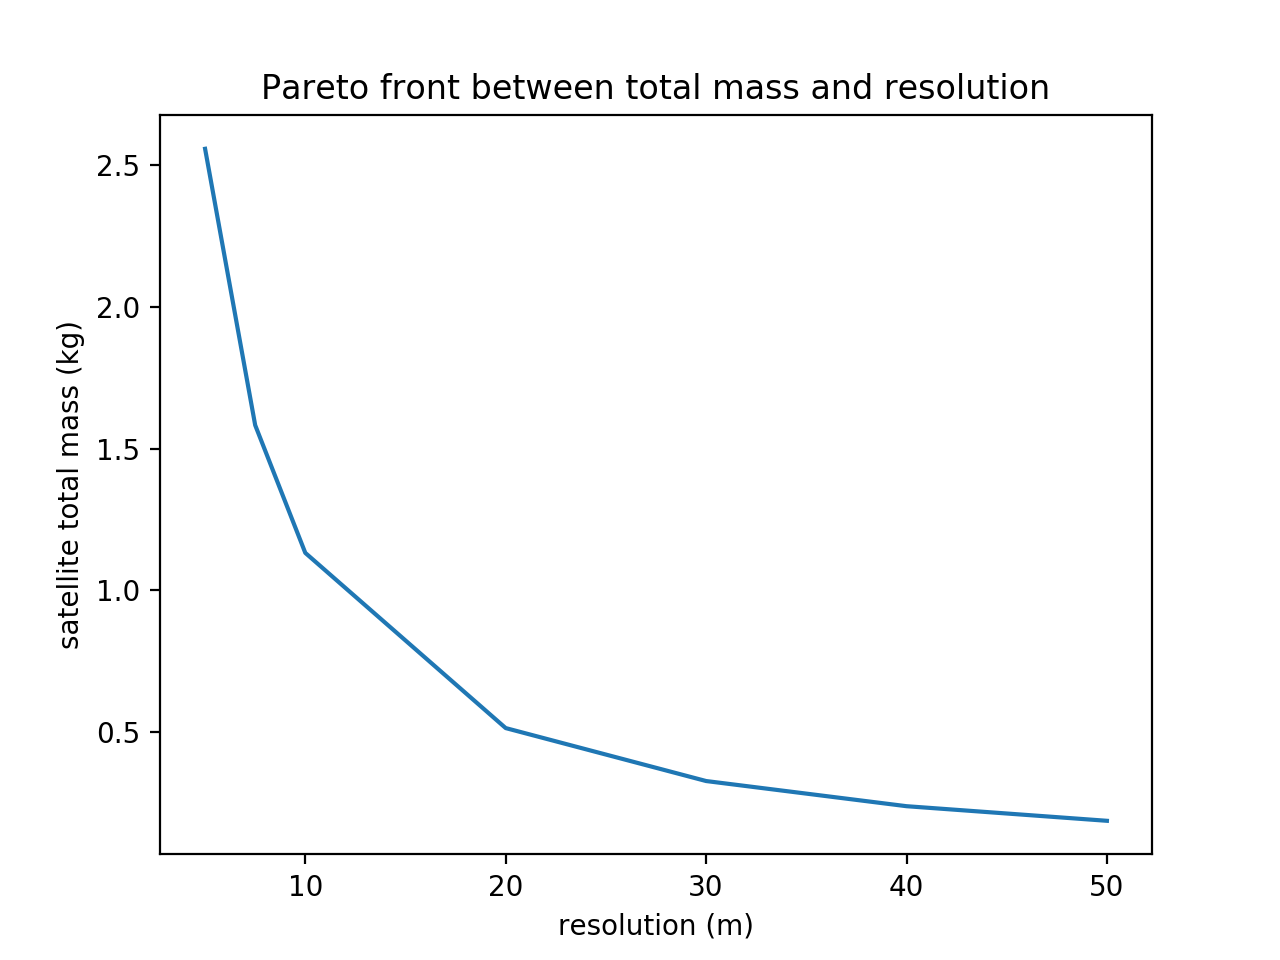

In [11]:
plt.plot(sol["variables"]["xp_{req}"], sol["variables"]["m_t"])
plt.xlabel('resolution (m)')
plt.ylabel('satellite total mass (kg)')
plt.title('Pareto front between total mass and resolution')
plt.show()

In [18]:
print(sol.table())


Cost
----
 [ 2.56      0.187     ] [kg] 

Sweep Variables
---------------
xp_{req} : [ 5         50       ]  [m] required resolution

Free Variables
--------------
         | Mission.1
       T : [ 92.5      92.5     ]          [min]  period
       h : [ 400       400      ]          [km]   orbit altitude
  t_{DL} : [ 10.4      10.4     ]          [min]  downlink time

         | Mission.1/Satellite.1
    m_st : [ 0.512     0.0375   ]          [kg]   structural mass
     m_t : [ 2.56      0.187    ]          [kg]   spacecraft total mass

         | Mission.1/Satellite.1/Comms.1
  G_{rx} : [ 8.21e+03  8.21e+03 ]                 ground receive gain
  P_{tx} : [ 31.2      3.12     ]          [W]    spacecraft transmit power
 \lambda : [ 0.136     0.136    ]          [m]    transmit wavelength
    breq : [ 206       20.6     ]          [MBd]  bit rate required
    ebno : [ 40        40       ]                 engery per bit over noise spectral density
  f_{DL} : [ 0.112     0.112    ]    